In [26]:
%cd '/scratch/sk7898/l3embedding/classifier/sonyc_ust'
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import os
import random
import csv
import json
import glob
import pandas as pd
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import resampy
import librosa
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import StandardScaler
from matplotlib import cm
from metrics import confusion_matrix_coarse, micro_averaged_auprc, macro_averaged_auprc
from classify import load_embeddings, predict_mil, construct_mlp_mil
# New modules: oyaml and pandas
import oyaml as yaml

/scratch/sk7898/l3embedding/classifier/sonyc_ust


In [14]:
def micro_f1_classwise_thresh(df_dict, thresh_dict):
    mu = 0.5
    TPs, FPs, FNs = 0, 0, 0
    
    for coarse_id in df_dict.keys():
        threshold = thresh_dict[coarse_id]
        coarse_df = df_dict[coarse_id]
        coarse_thresholds = coarse_df["threshold"]
        row = coarse_df[coarse_thresholds>=threshold].iloc[-1]
        
        TPs += row["TP"]
        FPs += row["FP"]
        FNs += row["FN"]
    
    precision = TPs / np.maximum(TPs + FPs, mu)
    recall = TPs / np.maximum(TPs + FNs, mu)
    f1 = 2 / (1/precision + 1/recall)
    
    return f1

In [15]:
def evaluate_df(gt_df, pred_df, yaml_dict, mode='coarse'):
    # NOTE: Make sure mode matches pred_df!

    # Set minimum threshold.
    min_threshold = 0.01

    # Make sure the size of the tables match
    if not (len(gt_df) == len(pred_df)):
        err_msg =\
            "Size mismatch between ground truth ({} files) " \
            "and prediction table ({} files)."
        raise ValueError(err_msg.format(len(gt_df), len(pred_df)))

    # Initialize dictionary of DataFrames.
    df_dict = {}

    # Loop over coarse categories.
    for coarse_id in yaml_dict:
        # List columns corresponding to that category
        if mode == "coarse":
            columns = [str(coarse_id)]
        else:
            columns = [column for column in pred_df.columns
                if (str(column).startswith(str(coarse_id))) and
                   ("-" in str(column)) and
                   (not str(column).endswith("X"))]

        # Sort columns in alphanumeric order.
        columns.sort()

        # Restrict prediction to columns of interest.
        restricted_pred_df = np.clip(pred_df[columns], 0.0, 1.0)

        # Restrict ground truth to columns of interest.
        restricted_gt_df = np.clip(gt_df[columns], 0.0, 1.0)

        # Aggregate all prediction values into a "raveled" vector.
        # We make an explicit numpy, so that the original DataFrame
        # is left unchanged.
        thresholds = np.ravel(np.copy(restricted_pred_df.values))

        # Sort in place.
        thresholds.sort()

        # Skip very low values.
        # This is to speed up the computation of the precision-recall curve
        # in the low-precision regime.
        thresholds = thresholds[np.searchsorted(thresholds, min_threshold):]
        thresholds = np.append(thresholds, 1.0)
        thresholds = np.unique(thresholds)[::-1]

        # Count number of thresholds.
        n_thresholds = len(thresholds)
        TPs = np.zeros((n_thresholds,)).astype('int')
        FPs = np.zeros((n_thresholds,)).astype('int')
        FNs = np.zeros((n_thresholds,)).astype('int')

        # FINE MODE.
        if mode == "fine":
            incomplete_tag = str(coarse_id) + "-X"

            # Load ground truth as numpy array.
            Y_true = restricted_gt_df.values
            is_true_incomplete = gt_df[incomplete_tag].values

            # Loop over thresholds in a decreasing order.
            for i, threshold in enumerate(thresholds):
                # Threshold prediction for complete tag.
                Y_pred = restricted_pred_df.values >= threshold

                # Threshold prediction for incomplete tag.
                is_pred_incomplete =\
                    pred_df[incomplete_tag].values >= threshold

                # Evaluate.
                TPs[i], FPs[i], FNs[i] = confusion_matrix_fine(
                    Y_true, Y_pred, is_true_incomplete, is_pred_incomplete)

        # COARSE MODE.
        elif mode == "coarse":
            # Load ground truth as numpy array.
            Y_true = restricted_gt_df.values

            # Loop over thresholds in a decreasing order.
            for i, threshold in enumerate(thresholds):
                # Threshold prediction.
                Y_pred = restricted_pred_df.values >= threshold

                # Evaluate.
                TPs[i], FPs[i], FNs[i] = confusion_matrix_coarse(Y_true, Y_pred)

        # Build DataFrame from columns.
        eval_df = pd.DataFrame({
            "threshold": thresholds, "TP": TPs, "FP": FPs, "FN": FNs})

        mu = 0.5
        eval_df["P"] = TPs / np.maximum(TPs + FPs, mu)
        eval_df["R"] = TPs / np.maximum(TPs + FNs, mu)
        eval_df["F"] = 2 / (1/eval_df["P"] + 1/eval_df["R"])

        # Store DataFrame in the dictionary.
        df_dict[coarse_id] = eval_df

    # Return dictionary.
    return df_dict

In [16]:
def parse_coarse_prediction(pred_df, coarse_dict):

    # Collect tag names as strings and map them to coarse ID pairs.
    rev_coarse_dict = {"_".join([str(k), coarse_dict[k]]): k
        for k in coarse_dict}

    # Assign a predicted column to each coarse key, by using the tag as an
    # intermediate hashing step.
    pred_coarse_dict = {}
    for c in rev_coarse_dict:
        if c in pred_df:
            pred_coarse_dict[str(rev_coarse_dict[c])] = pred_df[c]
        else:
            pred_coarse_dict[str(rev_coarse_dict[c])] = np.zeros((len(pred_df),))
            warnings.warn("Column not found: " + c)

    # Copy over the audio filename, split and sensor_id strings corresponding to each sample.
    pred_coarse_dict["audio_filename"] = pred_df["audio_filename"]
    pred_coarse_dict["new_split"] = pred_df["new_split"]
    pred_coarse_dict["sensor_id"] = pred_df["sensor_id"]
    pred_coarse_dict["grp_id"] = pred_df["grp_id"]

    # Build a new Pandas DataFrame with coarse keys as column names.
    pred_coarse_df = pd.DataFrame.from_dict(pred_coarse_dict)

    pred_coarse_df.sort_values('audio_filename')
    pred_coarse_df.reset_index(inplace=True)
    if 'index' in pred_coarse_df.keys():
        pred_coarse_df = pred_coarse_df.drop(columns=['index'])

    return pred_coarse_df

def filter_ground_truth(ann_df, aggregate=True):
    
    gt_df = ann_df.groupby("audio_filename", group_keys=False).max()
    
    gt_df.reset_index(inplace=True)
    if 'index' in gt_df.keys():
        gt_df = gt_df.drop(columns=['index'])
    return gt_df

def parse_ground_truth(ann_df, coarse_dict):

    gt_df = filter_ground_truth(ann_df)

    # Rename coarse columns.
    coarse_renaming = {
        "_".join([str(c), coarse_dict[c], "presence"]): str(c)
        for c in coarse_dict}
    gt_df = gt_df.rename(columns=coarse_renaming)

    gt_df = gt_df.sort_values('audio_filename')

    gt_df.reset_index(inplace=True)
    if 'index' in gt_df.keys():
        gt_df = gt_df.drop(columns=['index'])

    return gt_df

def evaluate_sgrp_df(gt_df, pred_df, coarse_dict, grp_by='grp_id'):
    
    dicts = {}
    # Do not consider train data from each sensor group
    sgrps = pred_df[(pred_df['new_split'] == 'validate') | (pred_df['new_split'] == 'test')][grp_by].unique().tolist()
        
    for gid in sgrps:
        gt = gt_df[gt_df[grp_by] == gid]
        pred = pred_df[pred_df['grp_id'] == gid]
        gt = gt.drop(columns=['new_split', grp_by])
        pred = pred.drop(columns=['new_split', grp_by])
        dicts[gid] = evaluate_df(gt, pred, coarse_dict)
    return dicts

def evaluate(prediction_data, annotation_data, coarse_dict, grp_by='grp_id'):

    # Parse ground truth.
    gt_df = parse_ground_truth(annotation_data, coarse_dict)
    pred_df = parse_coarse_prediction(prediction_data, coarse_dict)

    flist = [value for value in gt_df['audio_filename'].unique().tolist() 
             if value in pred_df['audio_filename'].unique().tolist()] 
    pred_df = pred_df[pred_df['audio_filename'].isin(flist)]
    gt_df = gt_df[gt_df['audio_filename'].isin(flist)]

    if grp_by:
        return evaluate_sgrp_df(gt_df, pred_df, coarse_dict, grp_by=grp_by)
    else:
        return evaluate_df(gt_df, pred_df, coarse_dict)

In [61]:
np.random.seed(42)
version = 'v0.4'
cls_list = ['engine', 'machinery-impact', 'non-machinery-impact', 'powered-saw',
            'alert-signal', 'music', 'human-voice', 'dog'
           ]
cls = cls_list[7]
SONYC_PATH = '/scratch/work/sonyc/sonyc/ust/annotations'
META_FOLDER = '/scratch/sk7898/l3embedding/notebooks/data'
DATA_FOLDER = os.path.join('/scratch/sk7898/l3embedding/notebooks/data', version)
NEW_ANNOTATION_DIR = os.path.join(DATA_FOLDER, cls)

THRESH_DICT = {
    1: 0.85,
    2: 0.2,
    3: 0.2,
    4: 0.2,
    5: 0.7,
    6: 0.1,
    7: 0.3,
    8: 0.1
}

annotation_path = os.path.join(NEW_ANNOTATION_DIR, 'annotations.csv')
taxonomy_path = os.path.join(SONYC_PATH, '{}/dcase-ust-taxonomy.yaml'.format(version))
annotation_data = pd.read_csv(annotation_path).sort_values('audio_filename')

#coarse_dict from taxonomy
with open(taxonomy_path, 'r') as f:
    taxonomy = yaml.load(f, Loader=yaml.Loader)

coarse_dict = {k: v for k, v in taxonomy['coarse'].items() if v == cls} 

# Path to the embeddings extracted from original L3 trained on env data
embs_dir = '/scratch/sk7898/sonyc_output/embeddings/' + version
emb_dir = os.path.join(embs_dir, 'features/sonyc_ust/l3/melSpec_20200304183233_48000_256_242_2048')

arch_str = '0_0' #'1_128'
# Path to MIL classifier trained with v0.4 training data
cls_prefix = 'classifier/sonyc_ust/mil/binary/melSpec_20200304183233_48000_256_242_2048'
cls_path = os.path.join(embs_dir, cls_prefix, '{}/{}/results'.format(cls, arch_str))
output_path = os.path.join(cls_path, 'output.csv')
scaler_path = os.path.join(cls_path, 'stdizer.pkl')

In [62]:
out = pd.read_csv(output_path)

df_dicts = evaluate(
                    out,
                    annotation_data,
                    coarse_dict, 
                    grp_by='grp_id'
            )

In [63]:
grp_metrics = {}

# df_dict has per coarse class metrics for each sensor group id
for sgrp, df_dict in df_dicts.items():
    split = out[out['grp_id'] == sgrp]['new_split'].iloc[0]
    s_name = split if split == 'test' else 'validate'
    g_name = '{}: {}'.format(sgrp, s_name)
    grp_metrics[g_name] = {}
    micro_auprc, eval_df = micro_averaged_auprc(df_dict, return_df=True)
    macro_auprc, class_auprc = macro_averaged_auprc(df_dict, return_classwise=True)

    grp_metrics[g_name]["micro_auprc"] = micro_auprc
    grp_metrics[g_name]["macro_auprc"] = macro_auprc
    grp_metrics[g_name]["micro_f1"] = micro_f1_classwise_thresh(df_dict, THRESH_DICT)

/scratch/sk7898/miniconda3/envs/l3embedding-tf-2-gpu/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


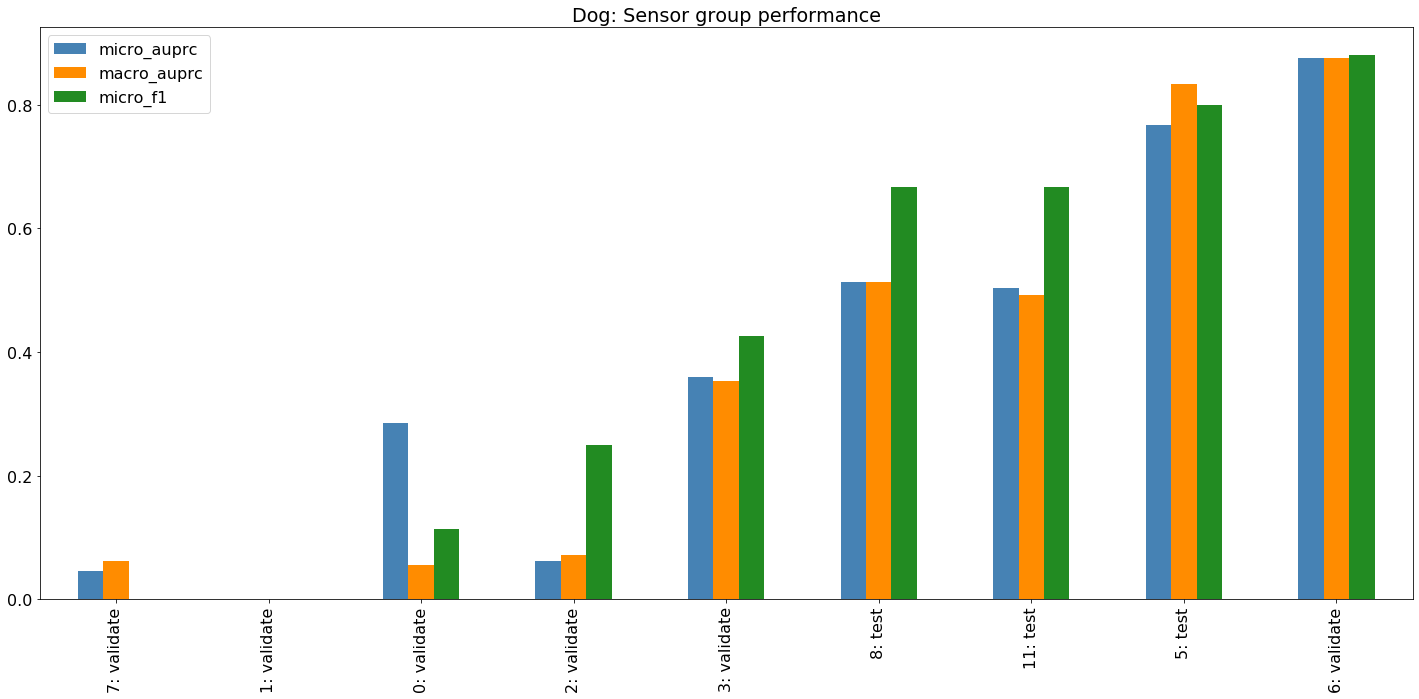

In [64]:
plt.rcParams.update({'font.size': 16}) 
metrics = ['micro_auprc', 'macro_auprc', 'micro_f1']
colors = ['steelblue', 'darkorange', 'forestgreen']

fig, ax = plt.subplots(figsize=(20, 10))
grp_metrics_df = pd.DataFrame.from_dict(grp_metrics, orient='index', columns=metrics)
grp_metrics_df = grp_metrics_df.sort_values(by=['micro_f1'])
grp_metrics_df.plot.bar(ax=ax, color=colors)
x_min, x_max = ax.get_xlim()
ax.set_title('{}: Sensor group performance'.format(cls.capitalize()))    
plt.tight_layout()